## Income Classification Ensemble Modeling with Sklearn Pipelines

The goal of this kernel is to use an ensemble of several different models to predict whether a person will make more or less than 50K a year. The steps of this process are the following:

    1) Conduct EDA of the dataset, remove redundant features
    2) Create format data and create sklearn pipelines to help format data for modeling
    3) Create the models and run initial cross-validation testing
    4) Tune hyper-parameters of all of our models
    5) Create ensemble estimator and compare with individual estimators.
    
    
#### Glossary:
    1. EDA and Preprocessing
        1.1. Load Data
        1.2. Format Feature Names
        1.3. Feature Analysis
        1.4. Remove Redundant Features
        1.5. Feature Correlation
        1.6. Datatype Preprocessing
        1.7. Decision Tree as EDA
        
    2. Data Transformation Pipeline
        2.1. Create a Holdout Set
        2.2. Creating the Pipeline
    
    3. Model Creation
        3.1. Creating Estimator Pipelines
        3.2. Initial Model Scoring
    
    4. Hyper-Parameter Tuning
        4.1. Parameter Tuning: XGB
        4.2. Parameter Tuning: Random Forest
        4.3. Parameter Tuning: Logistic Regression
        4.4. Parameter Tuning: SVM
        4.5. Post-Tuning Scores
        
    5. Ensembling
        5.1. Learning Curves
        5.2. Tree-Based Feature Importance
        5.3. Estimator Prediction Correlation
        5.4. Estimator Selection
        5.5. Ensemble Creation and Final Testing
        

## Part 1: EDA and Preprocessing

### 1.1: Load Data

In [2]:
#import data into dataframe
import pandas as pd
data=pd.read_csv('../input/income_evaluation.csv')
import warnings
warnings.filterwarnings('ignore')

### 1.2: Format Feature Names

In [3]:
data.columns=[x.strip() for x in data.columns]
data=data.apply(lambda x: x.str.strip() if x.dtype=='object' else x)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1.3: Feature Analysis

In [5]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


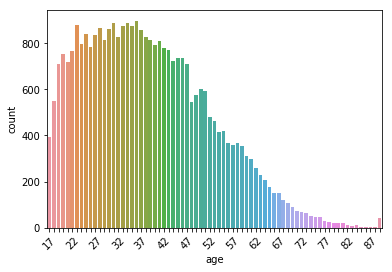

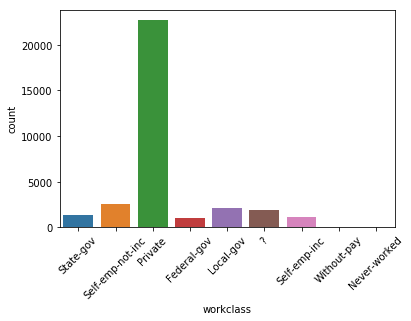

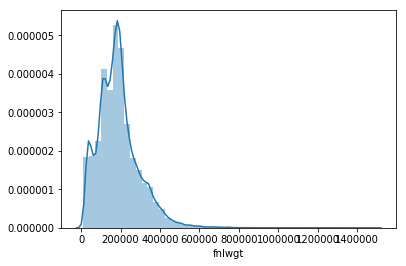

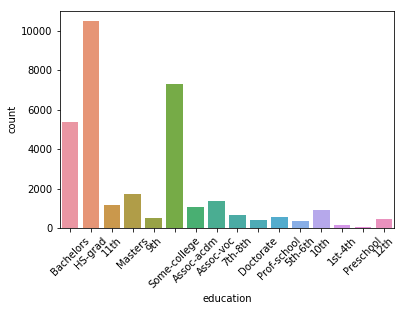

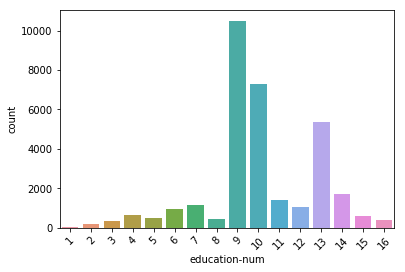

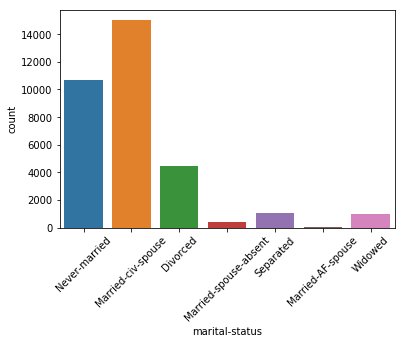

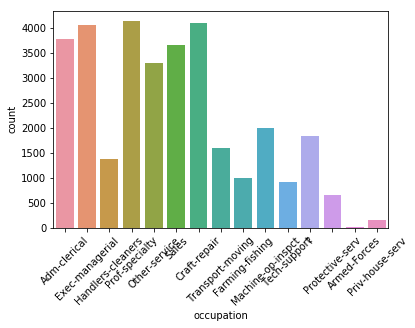

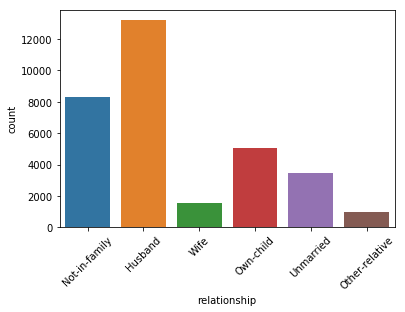

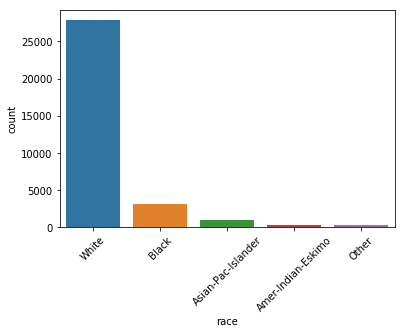

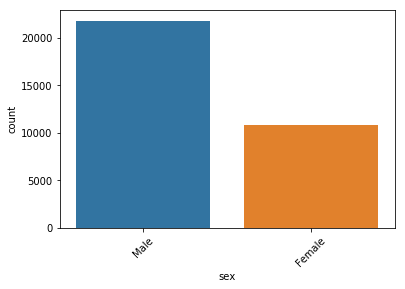

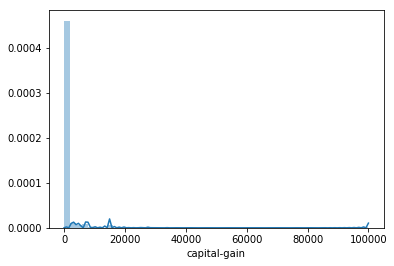

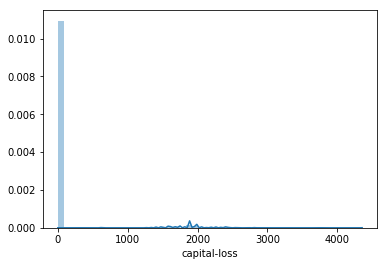

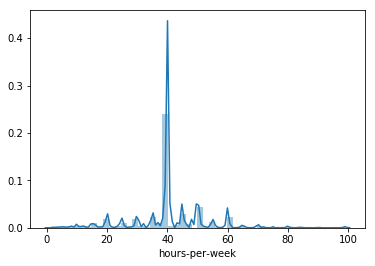

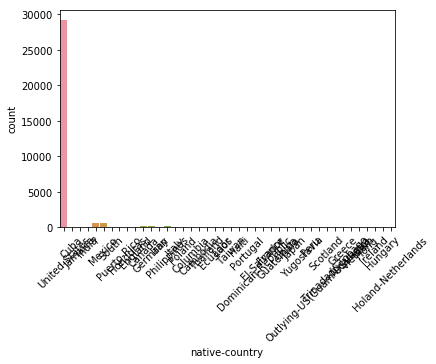

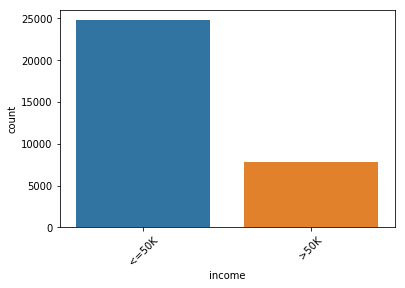

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, col in enumerate(data.columns):
    plt.figure(i)
    if (data[col].dtype=='object')|(col=='education-num')|(col=='age'):
        plot=sns.countplot(data[col])
        
        for index, item in enumerate(plot.get_xticklabels()):
            item.set_rotation(45)
            
            if col=='age':
                if index % 5 != 0:
                    item.set_visible(False)
                
            
    else:
        plot=sns.distplot(data[col])
    plot

In [7]:
target=data['income']
target=target.map({'<=50K':False,'>50K':True})
target=target.astype('bool')
data=data.drop(columns=['income'])

### 1.4: Remove Redundant Features

We will remove 'education-num' for now, as we will use the category names so we can interperet a decision tree. Before modeling we will one-hot encode the education feature.

In [8]:
#remove redundant features
data=data.drop(columns=['education-num'])


### 1.5: Feature Correlation

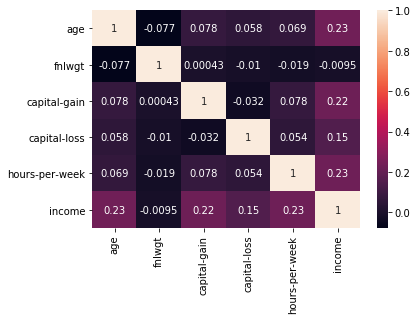

In [9]:
sns.heatmap(data.select_dtypes(exclude='object').assign(income=target).corr(),annot=True)

#### Regression Matrix for Categorical Variables
In order to produce a correlation matrix for categorical variables, I utilized the Cramer's V measure, which is based on Pearson's chi-squared statistic. I also used uncertainty coefficients as an asymmetric measure between the categorical variables. You can learn more about this [here](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9).

The link for the github repo of the dython package is https://github.com/shakedzy/dython

In [ ]:
from dython.nominal import associations
associations(dataset=data.select_dtypes(include='object').assign(age=data['age'],income=target), nominal_columns='all',plot=True)
associations(dataset=data.select_dtypes(include='object').assign(age=data['age'],income=target),theil_u=True, nominal_columns='all',plot=True)


### 1.6: Datatype Processing
We will start by making sure every column of our dataframe is of either numerical, categorical, or boolean datatypes. This will allow us to pass the data through a transformation pipeline.

In [10]:
from sklearn.preprocessing import label_binarize

def correct_dtypes(data):
    cat_cols=data.select_dtypes('object').columns.values
    data[cat_cols]=data[cat_cols].astype('category')
    
    data['sex']=data['sex'].map({'Female':0,'Male':1}).astype('bool')
    data=data.rename(columns={'sex':'female'})
    return data

data=correct_dtypes(data)
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,female,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba


### 1.7: Decision Tree as EDA
Since we will be using tree-based methods as apart of our ensemble, I want to see how a basic decision tree would interact with our dataset. I will start by by creating a one-hot encoded dataset to fit onto a decision tree classifier.

In [11]:
cat=data.select_dtypes(include='category')
cat=pd.get_dummies(cat, columns=cat.columns.values,prefix=cat.columns.values)
data_oh=pd.concat([data.select_dtypes(exclude='category'),cat],axis=1)

data_oh.head()

,age,fnlwgt,female,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,True,2174,0,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,True,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,True,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,True,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,False,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import pydot

#data_oh=data_oh.drop(columns=['fnlwgt'])
tree=DecisionTreeClassifier().fit(data_oh,target)

with open("tree1.dot", 'w') as dot:
    dot = export_graphviz(tree,
                          out_file=dot,
                          max_depth = 5,
                          impurity = True,
                          class_names = ['<=50K','>50K'],
                          feature_names = data_oh.columns.values,
                          rounded = True,
                          filled= True )

    
# Annotating chart with PIL
(graph,) = pydot.graph_from_dot_file('tree1.dot')

graph.write_png('tree1.png')
PImage('tree1.png')


#### Next Step: sum all of the dummy variable importances and divide by total

In [ ]:
import numpy as np
feat_impt=pd.DataFrame(data=tree.feature_importances_).T
feat_impt.columns=data_oh.columns.values

names = list(data.columns.values)

feature_importances=pd.DataFrame()
for column in names:
    value=feat_impt.filter(regex=column)
    value=value.mean(axis=1)
    feature_importances[column]=value

#feature_importances=pd.melt(feature_importances)
p=sns.barplot(data=feature_importances)
p.set_xticklabels(p.get_xticklabels(),rotation=45)
feature_importances

It looks like the tree is grabbing onto the fnlwgt feature pretty strongly. Earlier, we found that there was a near-zero correlation between income and fnlwgt. This feature could create a lot of noise that will overfit our models, so let's remove this it from our dataset.

In [12]:
data=data.drop(columns=['fnlwgt'])
data_oh=data_oh.drop(columns=['fnlwgt'])

## Part 2: Data Transformation Pipeline
In order to simplify data transformation among several models, and to make sure everything is consistent, I opted to use sklearn pipelines to transform our data before we throw it into an estimator.

### 2.1: Creating a Holdout Set
We will create a holdout set that we will use to evalulate our model at the very end. This will hopefully prevent data leakage into our models.

In [ ]:
#split data into train and test
#we will train our model with data/target evalulate our model at the very end with eval_data/eval_taret

from sklearn.model_selection import train_test_split


data, eval_data, target, eval_target = train_test_split(data,target,test_size=.20)

### 2.2: Creating the Transformation Pipeline
The first step of our estimator pipelines will be a transformer pipeline. The transformer will complete the following transformations:

    1. Numerical Data:
        a) Imputation transformer to fill in missing values should they exist
        b) Standard Scaler to normalize our numerical data
        
    2. Catecorical Data
        a) String indexer to index each of our strings with a numerical value
        b) One-hot encoder to allow for categorical variables to be used in our models.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer',SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder()),
        ]))  # categoricals close
    ])),  # features close
])  # pipeline close

## Part 3: Model Creation

### 3.1: Creating Estimator Pipelines

First, I will create several estimators to be used in our ensembele model. Next, I will create a dictionary of pipelines corresponding to each each estimator, with each including the transformer pipeline we just built as the first step. Each model pipeline will be fit with our training data.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
    ('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    ('svc',LinearSVC()),
    ('deep_nn',MLPClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]

pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    pipe.fit(data,target)
    pipes[pipe.steps[1][0]]=pipe



/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### 3.2: Initial Model Scoring

We will test our model with initial parameters using four metrics: roc-auc, accuracy, and log_loss

In [16]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss

_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

estimator_names=[model[0] for model in estimators]

def plot_estimators(estimators=estimator_names,n_splits=5,metrics=['f1','auc','accuracy','logloss']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,data,target,scoring=metrics,cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)


In [17]:
metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

In [ ]:
plot_estimators()

## Part 4: Hyper-Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_param(model,param_grid,refit='auc',chart=None,data=data,target=target,cv=5):
    
    param_grid={model+'__'+key : param_grid[key] for key in param_grid.keys()}

    xgbcv=GridSearchCV(pipes[model],param_grid,scoring=metrics,refit=refit,cv=cv)
    xgbcv.fit(data,target)

    print('best score: '+str(xgbcv.best_score_))
    print('best params: '+str(xgbcv.best_params_))
    results=pd.DataFrame(xgbcv.cv_results_)
    
    if 'line' in chart:
        for i,param in enumerate(param_grid.keys()):
            graph_data=results[['param_'+param,'mean_test_'+refit,'mean_train_'+refit]]
            graph_data=graph_data.rename(columns={'mean_test_'+refit:'test','mean_train_'+refit:'train'})
            graph_data=graph_data.melt('param_'+param, var_name='type',value_name=refit)
            plt.figure(i)
            plot=sns.lineplot(x='param_'+param,y=refit,hue='type',data=graph_data)
            
    if 'heatmap' in chart:
        assert len(param_grid) == 2,  'heatmap only works with 2 params, {} passed'.format(str(len(param_grid)))
        
        param1=list(param_grid.keys())[0]
        param2=list(param_grid.keys())[1]

        graph_data=results[['param_'+param1,'param_'+param2,'mean_test_'+refit]]
        graph_data=graph_data.pivot(index='param_'+param1,columns='param_'+param2,values='mean_test_'+refit)
        sns.heatmap(graph_data,annot=True,xticklabels=True,yticklabels=True).set(xlabel=param2,ylabel=param1)


### 4.1: Parameter Tuning: XGB

In [ ]:
pipes['xgb'].named_steps['xgb'].get_params()

In [ ]:
param_grid={'n_estimators': [100,200,300,400,500,600,700,800,900]} 
tune_param('xgb',param_grid,chart='line')

In [ ]:
pipes['xgb'].set_params(**{'xgb__n_estimators': 1000})

In [ ]:
param_grid={'max_depth':[3,5,7,9]}
tune_param('xgb',param_grid,chart='line')

In [ ]:
pipes['xgb'].set_params(**{'xgb__max_depth': 3})

In [ ]:
param_grid={'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
tune_param('xgb',param_grid,chart='line')

In [ ]:
pipes['xgb'].set_params(**{'xgb__learning_rate': 0.1})

In [ ]:
param_grid={'subsample':[0.8,0.85,0.9,0.95,1]}
tune_param('xgb',param_grid,chart='line')


In [ ]:
pipes['xgb'].set_params(**{'xgb__learning_rate': 0.95})

In [ ]:
param_grid={'colsample_bytree':[0.3,0.5,0.7,0.9,1]}
tune_param('xgb',param_grid,chart='line')

In [ ]:
pipes['xgb'].set_params(**{'xgb__colsample_bytree': 0.3})

In [ ]:
param_grid={'gamma':[0,1,5]}
tune_param('xgb',param_grid,chart='line')

In [ ]:
pipes['xgb'].set_params(**{'xgb__gamma': 5})
pipes['xgb'].named_steps['xgb'].get_params()

### 4.2: Parameter Tuning: Random Forest

In [ ]:
pipes['random_forest'].named_steps['random_forest'].get_params()

In [ ]:
pipes['random_forest'].set_params(**{'random_forest__n_estimators': 100})


In [ ]:
param_grid={'max_depth':[3,8,13,18]}
tune_param('random_forest',param_grid,chart='line')

In [ ]:
#we see that test auc plateaus at around 13-14ish
#for efficiency sake lets set max depth at 13
pipes['random_forest'].set_params(**{'random_forest__max_depth': 13})


In [ ]:
param_grid={'max_leaf_nodes':[5,10,15,20,25]}
tune_param('random_forest',param_grid,chart='line')

In [ ]:
param_grid={'n_estimators':[10,50,100,150,200,500]}
tune_param('random_forest',param_grid,chart='line')

In [ ]:
pipes['random_forest'].set_params(**{'random_forest__n_estimators': 50})

### 4.3: Parameter Tuning: Logistic Regression

In [ ]:
pipes['logistic'].named_steps['logistic'].get_params()

In [ ]:
pipes['lasso'].named_steps['lasso'].get_params()

In [ ]:
warnings.filterwarnings('ignore')
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
           'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
tune_param('logistic',param_grid,chart='heatmap')

In [ ]:
pipes['logistic'].set_params(**{'logistic__C': 1000, 'logistic__tol': 0.001})
pipes['lasso'].set_params(**{'lasso__C': 1000, 'lasso__tol': 0.001})


### 4.4: Parameter Tuning: SVM

In [ ]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}
tune_param('svc',param_grid,chart='linear')

In [ ]:
pipes['svc'].set_params(**{'svc__C': 1})

### 4.5: Post-Tuning Scores

Lets plot our estimators we tuned to see how much the new parameters improve performance.

In [ ]:
plot_estimators(['xgb','svc','logistic','lasso','random_forest'])

## Part 5: Ensemble

### 5.1: Learning Curves

Since we have a large number of features, let's plot some learning curves to help us visualize whether the model overfits in relation to the number of training examples

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

t=transformer
t.fit(data)
t=t.transform(data)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

to_plot=['xgb','random_forest','lasso','ridge']
for name in pipes.keys():
    if name in to_plot:
        g=plot_learning_curve(pipes[name].named_steps[name],name+' learning curves',t,target,cv=KFold(4),n_jobs=4)

105

### 5.2: Tree-Based Feature Importance

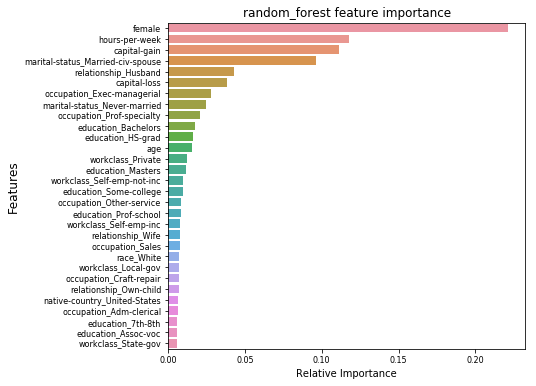

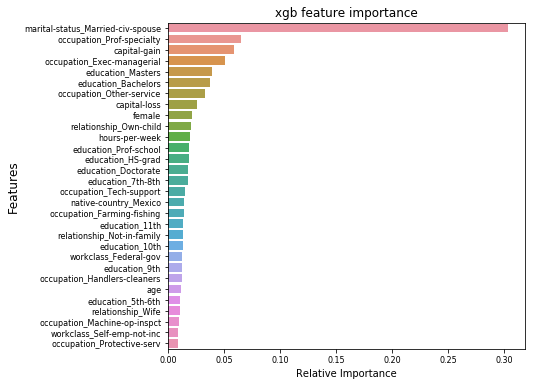

In [23]:
tree_based=['random_forest','xgb']
for name in pipes.keys(): 
    if name in tree_based:
        feat_impt=pipes[name].named_steps[name].feature_importances_
        graph_data=pd.DataFrame()

        graph_data['feature']=data_oh.columns.values
        graph_data['importance']=feat_impt
        graph_data_top=graph_data.nlargest(30,'importance')

        plt.figure(figsize=(6.4,6))
        g=sns.barplot(y='feature',x='importance',data=graph_data_top,orient='h')
        g.set_ylabel('Features',fontsize=12)
        g.set_xlabel('Relative Importance')
        g.set_title(name + " feature importance")
        g.tick_params(labelsize=8)
        

### 5.3:  Estimator Prediction Correlation

Before we create ensemble estimators, we should see how similar our models predict our holdout set. We will do this by predicting the holdout set and then creating a correlation heatmap between the estimator predictions.

In [ ]:
ensemble_results=pd.DataFrame()
for name,pipe in pipes.items():
    ensemble_results[name]=pipe.predict(eval_data)
sns.heatmap(ensemble_results.corr(),annot=True)

### 5.4: Estimator Selection

There appears to be some difference between our estimator predicionts. I'm going to remove the decision tree, ridge, and logistic estimators because of poor performance and high correlation with other estimators.

In [ ]:
del pipes['ridge'],pipes['decision_tree'],pipes['logistic']

### 5.5: Ensemble Creation and Final Testing

Let's make a voting ensemble including all of our estimators and compare it to the performance of each individual estimator

In [ ]:
def print_predictions(target,predictions):
    print('auc: '+str(roc_auc_score(target,predictions)))
    print('f1: '+str(f1_score(target,predictions)))
    print('accuracy: '+str(accuracy_score(target,predictions)))
    print('logloss: '+str(log_loss(target,predictions)))

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
vote.fit(data,target)
predictions=vote.predict(eval_data)

print_predictions(eval_target,predictions)



In [ ]:
for name in pipes.keys():
    print(name)
    predictions=pipes[name].predict(eval_data)
    print_predictions(eval_target,predictions)
    print()

It looks like a voting classifier using all of our estimators performed worse than our best individual estimator, xgboost. I'm now going to test out several combinations of estimators to see if we can't create a voting classifier that performs better than an individual xgboost.

For the sake of computation time, I will limit our final estimators to random_forest, xgb, deep_nn, and elastic_net.

In [ ]:
from itertools import combinations

final_estimators=['random_forest','xgb','deep_nn','elasticnet']

combos=[]
for L in range(2, len(final_estimators)+1):
    for subset in combinations(final_estimators, L):
        combos.append(list(subset))


combo_names=[]
auc=[]
f1=[]
logloss=[]
accuracy=[]

for combo in combos:
    estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
    vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
    vote.fit(data,target)
    predictions=vote.predict(eval_data)

    auc.append(roc_auc_score(eval_target,predictions))
    accuracy.append(accuracy_score(eval_target,predictions))
    logloss.append(log_loss(eval_target,predictions))
    f1.append(f1_score(eval_target,predictions))
    combo_names.append(str(list(combo)))
    
score=pd.DataFrame()
score['combo']=combo_names
score['auc']=auc
score['f1']=f1
score['accuracy']=accuracy

score


Looks like our best voter combination is xgb, deep_nn, and elasticnet.